# Spam Detection: Machine Learning mini project.

## Data collection

Import modules

In [74]:
from collections import Counter
from nltk.corpus import stopwords
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [75]:
data = pd.read_csv('data/spam.csv', encoding='latin-1')

In [76]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [77]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.rename(columns={'v1': 'label', 'v2': 'message'})
data["label"] = data["label"].map({'spam':1,'ham':0})
data.head(10)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


For simplicity, convert each word to lowercase.

In [78]:
data['message'] = data['message'].apply(lambda x: ' '.join(w.lower() for w in x.split()))
data.head(10)

,label,message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."
5,1,freemsg hey there darling it's been 3 week's n...
6,0,even my brother is not like to speak with me. ...
7,0,as per your request 'melle melle (oru minnamin...
8,1,winner!! as a valued network customer you have...
9,1,had your mobile 11 months or more? u r entitle...


## Data exploration

### Visualizations

Bar chart

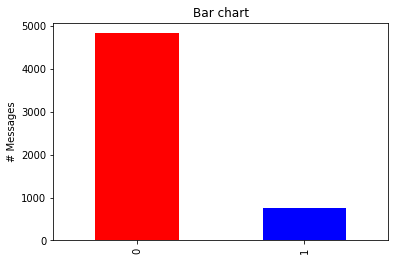

In [79]:
counts = pd.value_counts(data['label'], sort=True)
counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Bar chart')
plt.ylabel('# Messages')
plt.show()

Pie chart

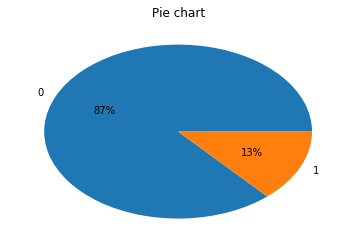

In [80]:
counts.plot(kind='pie', autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

### Text analytics

In [81]:
count_ham = None
count_spam = None
df_ham = None
df_spam = None
y_pos = None

def setup_ham():
    global count_ham, df_ham
    count_ham = Counter(' '.join(data[data['label'] == 0]['message']).split()).most_common(20)
    df_ham = pd.DataFrame.from_dict(count_ham)
    df_ham = df_ham.rename(columns={0: 'non-spam words', 1: 'count'})

def setup_spam():
    global count_spam, df_spam
    count_spam = Counter(' '.join(data[data['label'] == 1]['message']).split()).most_common(20)
    df_spam = pd.DataFrame.from_dict(count_spam)
    df_spam = df_spam.rename(columns={0: 'spam words', 1: 'count'})
    
def plot_ham():
    global df_ham, y_pos
    df_ham.plot.bar(legend=False)
    y_pos = np.arange(len(df_ham['non-spam words']))
    plt.xticks(y_pos, df_ham['non-spam words'])
    plt.title('Most frequent non-spam words')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.show()
    
def plot_spam():
    global df_spam, y_pos
    df_spam.plot.bar(legend=False, color='red')
    y_pos = np.arange(len(df_spam['spam words']))
    plt.xticks(y_pos, df_spam['spam words'])
    plt.title('Most frequent spam words')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.show()
    
def cloud_ham():
    ham_words = ' '.join(list(data[data['label'] == 0]['message']))
    ham_wc = WordCloud(width=512, height=512).generate(ham_words)
    plt.figure(figsize=(10, 8), facecolor='k')
    plt.imshow(ham_wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
def cloud_spam():
    spam_words = ' '.join(list(data[data['label'] == 1]['message']))
    spam_wc = WordCloud(width=512, height=512).generate(spam_words)
    plt.figure(figsize=(10, 8), facecolor='k')
    plt.imshow(spam_wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [82]:
setup_ham()
setup_spam()

Check the most frequently appearing words in spam and non-spam messages.

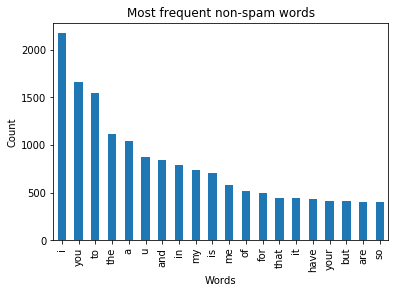

In [83]:
plot_ham()

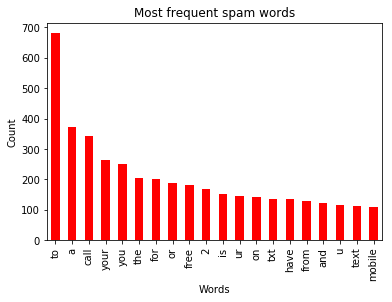

In [84]:
plot_spam()

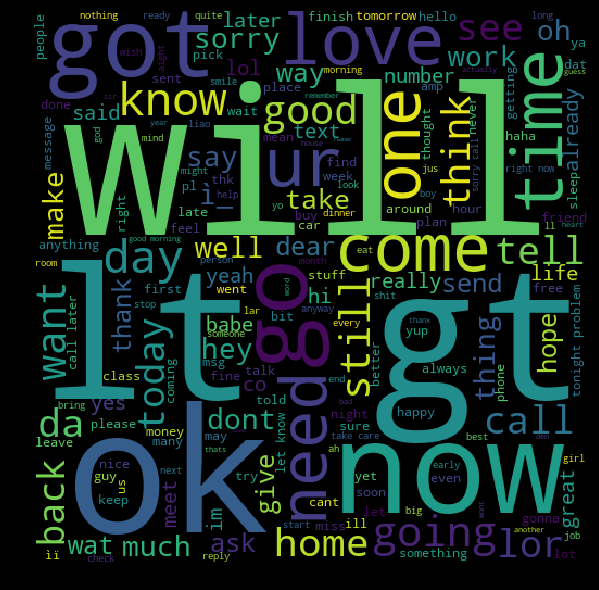

In [85]:
cloud_ham()

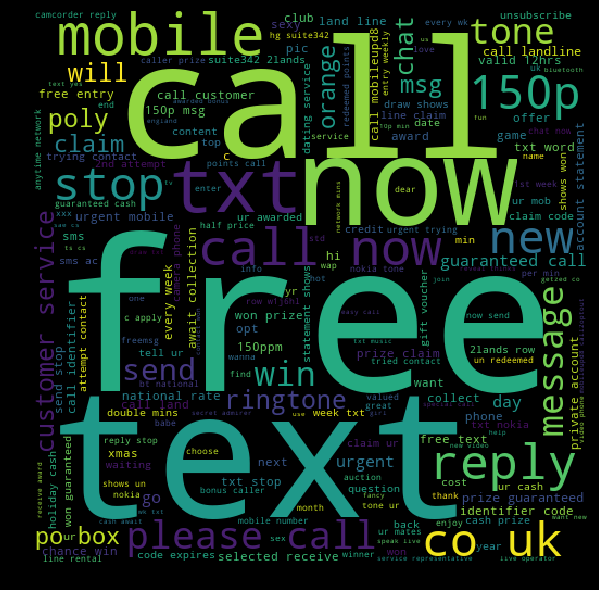

In [86]:
cloud_spam()

We see that the most common words are words that are commonly used in the English language (to, your, a, I, etc.) i.e., stop words. So, to make the model more accurate, we remove these words.

#### Stop words removal

In [87]:
stop = stopwords.words('english')
data['message'] = data['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
data.head(10)

,label,message
0,0,"go jurong point, crazy.. available bugis n gre..."
1,0,ok lar... joking wif u oni...
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor... u c already say...
4,0,"nah think goes usf, lives around though"
5,1,freemsg hey darling 3 week's word back! i'd li...
6,0,even brother like speak me. treat like aids pa...
7,0,per request 'melle melle (oru minnaminunginte ...
8,1,winner!! valued network customer selected rece...
9,1,mobile 11 months more? u r entitled update lat...


Now stem the words.

In [88]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

def stem_sentence(s):
    tokens = s.split()
    stems = [porter_stemmer.stem(t) for t in tokens]
    return ' '.join(stems)

data['message'] = data['message'].apply(stem_sentence)

In [89]:
data.head(10)

,label,message
0,0,"go jurong point, crazy.. avail bugi n great wo..."
1,0,ok lar... joke wif u oni...
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor... u c alreadi say...
4,0,"nah think goe usf, live around though"
5,1,freemsg hey darl 3 week' word back! i'd like f...
6,0,even brother like speak me. treat like aid pat...
7,0,per request 'mell mell (oru minnaminungint nur...
8,1,winner!! valu network custom select receivea å...
9,1,mobil 11 month more? u r entitl updat latest c...


Now let's check the most common words again.

In [90]:
setup_ham()
setup_spam()

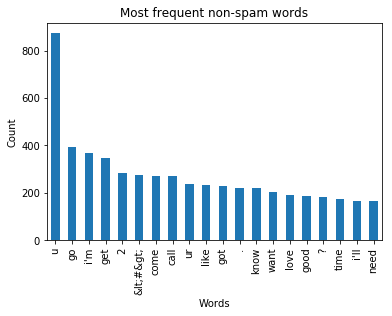

In [91]:
plot_ham()

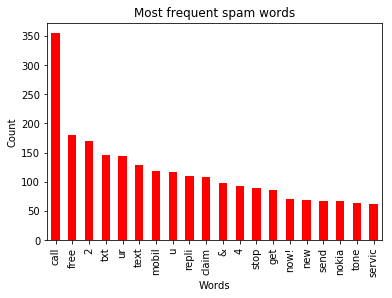

In [92]:
plot_spam()

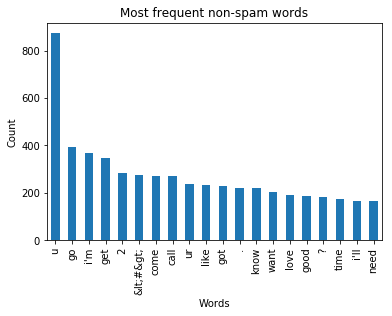

In [93]:
plot_ham()

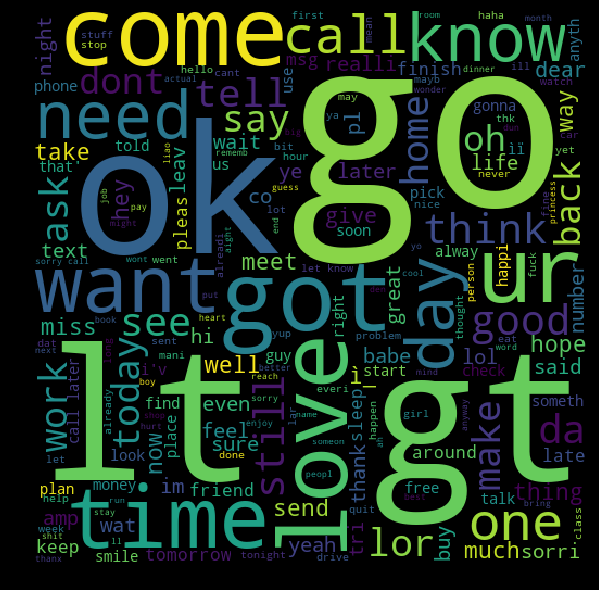

In [94]:
cloud_ham()

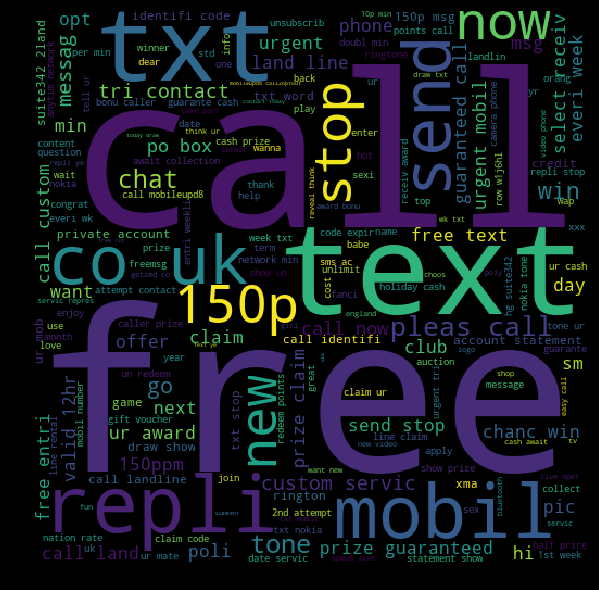

In [95]:
cloud_spam()

### Split data

We now split the data into training data (70%) and testing data (30%).

In [96]:
f = feature_extraction.text.CountVectorizer()
X = f.fit_transform(data['message'])

print(np.shape(X))

(5572, 8194)


Compare Word vectors and TF-IDF vectors.

In [97]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], test_size=0.3)

Now, training and testing data are ready. Train the model now.

In [98]:
def train_nb(X_train, y_train, X_test, y_test):

    alphas = np.arange(1/100, 50, 0.01)
    l = len(alphas)
    score_test = np.zeros(l)
    precision_test= np.zeros(l)
    count = 0

    for a in alphas:
        bayes = naive_bayes.MultinomialNB(alpha=a)
        bayes.fit(X_train, y_train)
        score_test[count]= bayes.score(X_test, y_test)
        precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
        count = count + 1
        
    return [alphas, score_test, precision_test]

In [99]:
a, s, p = train_nb(X_train, y_train, X_test, y_test)

In [100]:
matrix = np.matrix(np.c_[a, s, p])
model = pd.DataFrame(data=matrix, columns=['alpha', 'test accuracy', 'precision'])
model.head(10)

,alpha,test accuracy,precision
0,0.01,0.977871,0.899123
1,0.02,0.977273,0.895197
2,0.03,0.978469,0.899563
3,0.04,0.979067,0.903509
4,0.05,0.978469,0.896104
5,0.06,0.977871,0.892241
6,0.07,0.977273,0.891775
7,0.08,0.977871,0.892241
8,0.09,0.978469,0.896104
9,0.10,0.978469,0.896104


In [101]:
model.iloc[model['precision'].idxmax(), :]
model['precision'].max()

1.0

In [102]:
model[model['precision']==1].head(n=5)

,alpha,test accuracy,precision
1081,10.82,0.976675,1.0
1082,10.83,0.976675,1.0
1083,10.84,0.976675,1.0
1084,10.85,0.976675,1.0
1085,10.86,0.976675,1.0


In [103]:
def get_best_alpha():
    global X
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], test_size=0.3)

    alphas, scores, precisions = train_nb(X_train, y_train, X_test, y_test)
    
    matrix = np.matrix(np.c_[alphas, scores, precisions])
    model = pd.DataFrame(data=matrix, columns=['alpha', 'test accuracy', 'precision'])
    
    best_alpha = alphas[model[model['precision'] == model['precision'].max()]['test accuracy'].idxmax()]
    
    return best_alpha

In [109]:
best_alpha = get_best_alpha()
print(best_alpha)
print(model[model['alpha'] == best_alpha])

4.92
     alpha  test accuracy  precision
491   4.92       0.980263   0.984375


In [110]:
bayes = naive_bayes.MultinomialNB(alpha=best_alpha)
bayes.fit(X_train, y_train)

MultinomialNB(alpha=4.92, class_prior=None, fit_prior=True)

In [111]:
def check_message(m):
    pred = bayes.predict(f.transform([m]))
    if pred == 0:
        return 'Not Spam!'
    else:
        return 'Spam!'

In [112]:
check_message('Hello there! Nice talking to you!')

'Not Spam!'

In [113]:
check_message('Congratulations ur awarded $500')

'Spam!'